In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from mas.generate import ba_generate, random_generate
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

# 1. Ukol

In [2]:
size = 1000

normal_data = np.random.normal(size=size)
exponential_data = np.random.exponential(size=size)
power_law_data = np.random.power(2, size=size)
poisson_data = np.random.poisson(size=size)
lognormal_data = np.random.lognormal(size=size)

In [3]:
fit_normal_data = stats.norm.fit(normal_data)
fit_exponential_data = stats.expon.fit(exponential_data)
fit_power_law_data = stats.powerlaw.fit(power_law_data)
# fit_poisson_data = stats.poisson.fit(poisson_data)
fit_lognormal_data = stats.lognorm.fit(lognormal_data)

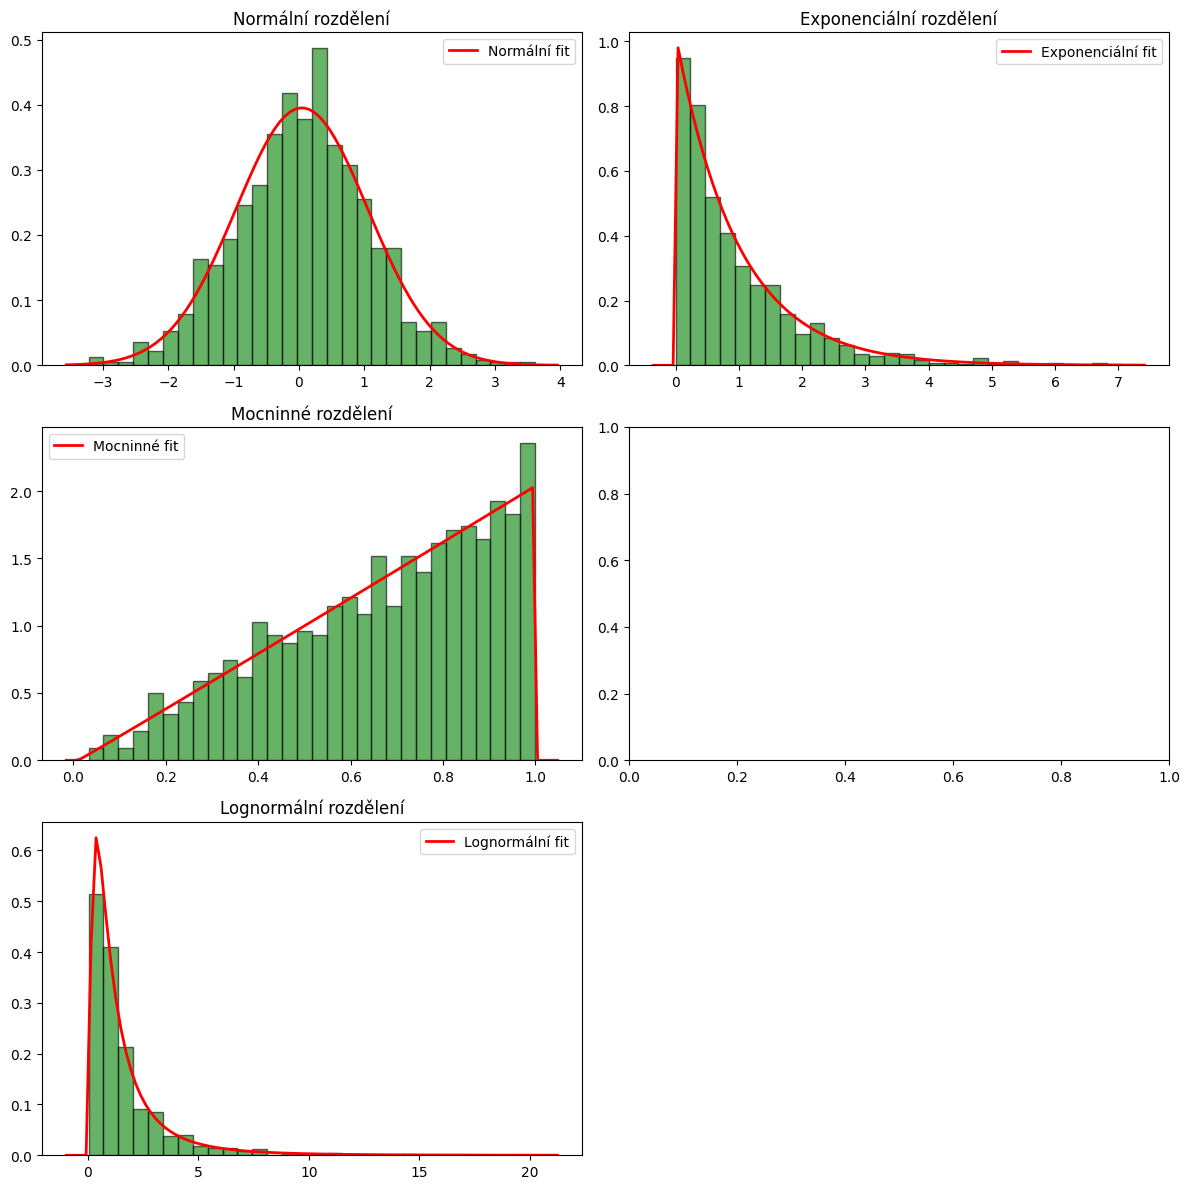

In [4]:
def plot_fit(data, dist_name, dist, params, bins=30):
    plt.hist(data, bins=bins, density=True, alpha=0.6, color="g", edgecolor="black")
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    pdf_fitted = dist.pdf(x, *params)
    plt.plot(x, pdf_fitted, "r-", lw=2, label=f"{dist_name} fit")
    plt.legend()


fig, axs = plt.subplots(3, 2, figsize=(12, 12))

# Normální rozdělení
axs[0, 0].set_title("Normální rozdělení")
plt.sca(axs[0, 0])
plot_fit(normal_data, "Normální", stats.norm, fit_normal_data)

# Exponenciální rozdělení
axs[0, 1].set_title("Exponenciální rozdělení")
plt.sca(axs[0, 1])
plot_fit(exponential_data, "Exponenciální", stats.expon, fit_exponential_data)

# Mocninné rozdělení
axs[1, 0].set_title("Mocninné rozdělení")
plt.sca(axs[1, 0])
plot_fit(power_law_data, "Mocninné", stats.powerlaw, fit_power_law_data)

# Lognormální rozdělení
axs[2, 0].set_title("Lognormální rozdělení")
plt.sca(axs[2, 0])
plot_fit(lognormal_data, "Lognormální", stats.lognorm, fit_lognormal_data)

axs[2, 1].axis("off")

plt.tight_layout()
plt.show()

In [5]:
def perform_ks_test(data, label, dist, params):
    result = stats.kstest(data, dist.cdf, args=params)
    print(f"{label}: {result.statistic}")


perform_ks_test(normal_data, "Normal", stats.norm, fit_normal_data)
perform_ks_test(exponential_data, "Exponential", stats.expon, fit_exponential_data)
perform_ks_test(power_law_data, "Power", stats.powerlaw, fit_power_law_data)
perform_ks_test(lognormal_data, "Log normal", stats.lognorm, fit_lognormal_data)

Normal: 0.020245700855947235
Exponential: 0.033576290696346045
Power: 0.017138637911434662
Log normal: 0.021625414394082665


# 2. Ukol

In [6]:
N = 5500

In [7]:
random_nx = random_generate(N, 0.0019)
ba_nx = ba_generate(N, 3)

In [8]:
random_degrees = [deg for _, deg in random_nx.degree()]
ba_degrees = [deg for _, deg in ba_nx.degree()]

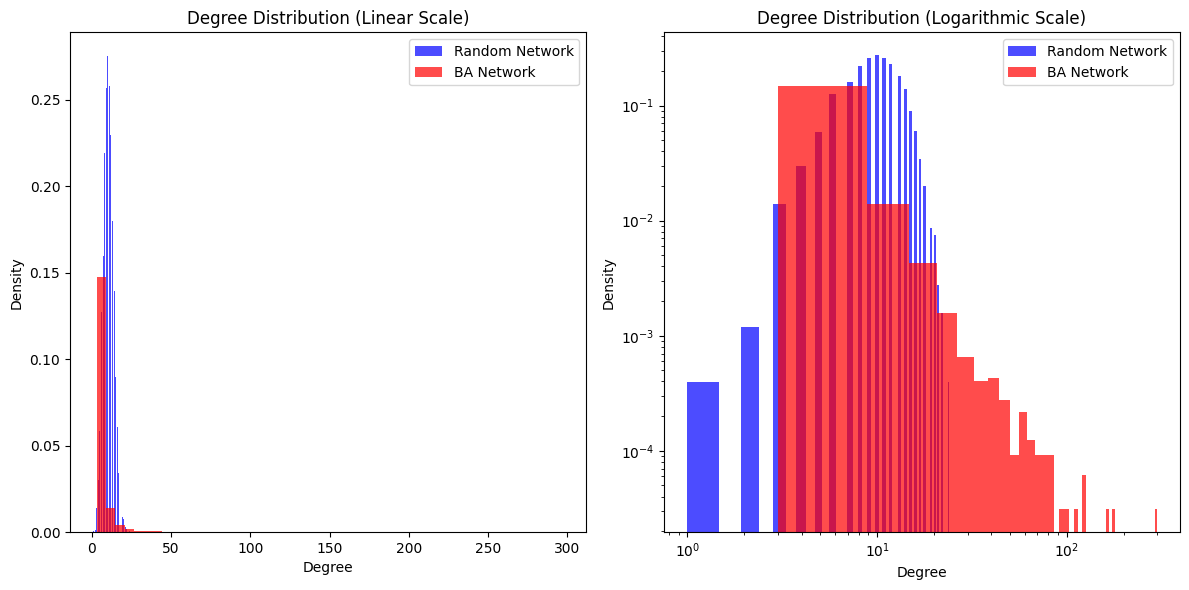

In [9]:
plt.figure(figsize=(12, 6))

# Linear scale
plt.subplot(1, 2, 1)
plt.hist(
    random_degrees,
    bins=50,
    alpha=0.7,
    label="Random Network",
    color="blue",
    density=True,
)
plt.hist(ba_degrees, bins=50, alpha=0.7, label="BA Network", color="red", density=True)
plt.title("Degree Distribution (Linear Scale)")
plt.xlabel("Degree")
plt.ylabel("Density")
plt.legend()

# Logarithmic scale
plt.subplot(1, 2, 2)
plt.hist(
    random_degrees,
    bins=50,
    alpha=0.7,
    label="Random Network",
    color="blue",
    density=True,
)
plt.hist(ba_degrees, bins=50, alpha=0.7, label="BA Network", color="red", density=True)
plt.xscale("log")
plt.yscale("log")
plt.title("Degree Distribution (Logarithmic Scale)")
plt.xlabel("Degree")
plt.ylabel("Density")
plt.legend()

plt.tight_layout()
plt.show()

In [10]:
scaler = MinMaxScaler()

In [11]:
df = []
degree_count = pd.Series(random_degrees).value_counts().sort_index()
degree_cumsum = degree_count.cumsum()
degree_cdf = degree_cumsum / degree_cumsum.iloc[-1]
degree_ccdf = 1 - degree_cdf

normalized_degrees = scaler.fit_transform(
    degree_count.index.values.reshape(-1, 1)
).flatten()

df.append(
    pd.DataFrame(
        {
            "X": normalized_degrees,
            "cdf": degree_cdf.values,
            "ccdf": degree_ccdf.values,
            "Dataset": "Random",
        }
    )
)

degree_count = pd.Series(ba_degrees).value_counts().sort_index()
degree_cumsum = degree_count.cumsum()
degree_cdf = degree_cumsum / degree_cumsum.iloc[-1]
degree_ccdf = 1 - degree_cdf

normalized_degrees = scaler.fit_transform(
    degree_count.index.values.reshape(-1, 1)
).flatten()

df.append(
    pd.DataFrame(
        {
            "X": normalized_degrees,
            "cdf": degree_cdf.values,
            "ccdf": degree_ccdf.values,
            "Dataset": "BA",
        }
    )
)

df = pd.concat(df)

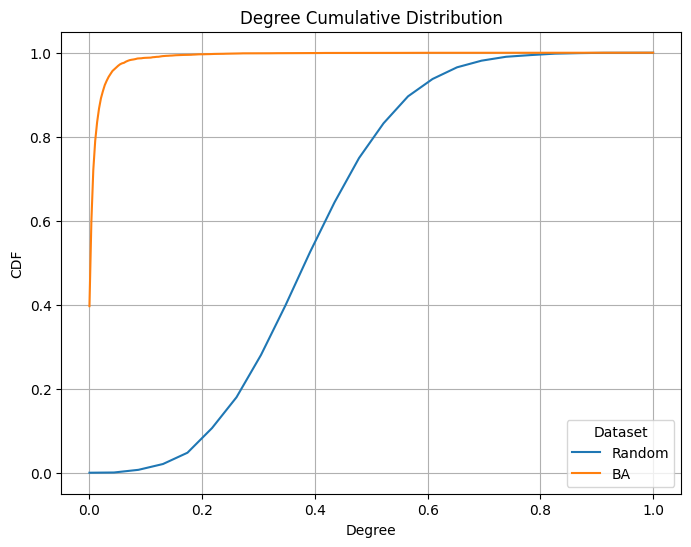

In [19]:
plt.figure(figsize=(8, 6))
sns.lineplot(data=df, x="X", y="cdf", hue="Dataset")
plt.title("Degree Cumulative Distribution")
plt.xlabel("Degree")
plt.ylabel("CDF")
plt.grid(True)
plt.show()

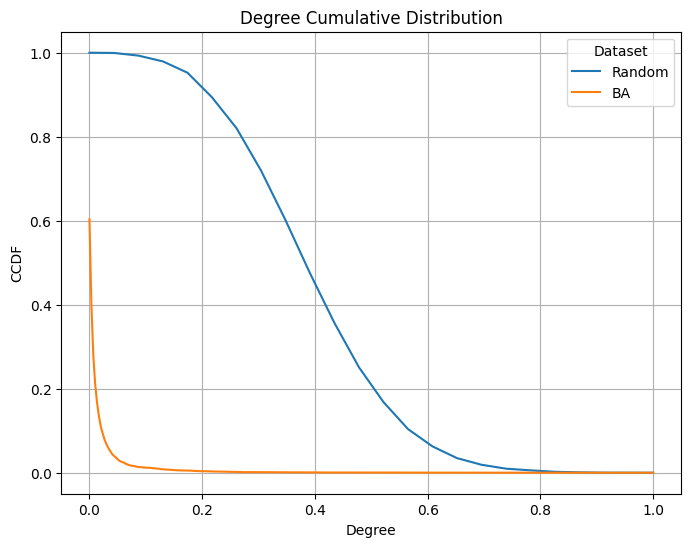

In [20]:
plt.figure(figsize=(8, 6))
sns.lineplot(data=df, x="X", y="ccdf", hue="Dataset")
plt.title("Degree Cumulative Distribution")
plt.xlabel("Degree")
plt.ylabel("CCDF")
plt.grid(True)
plt.show()

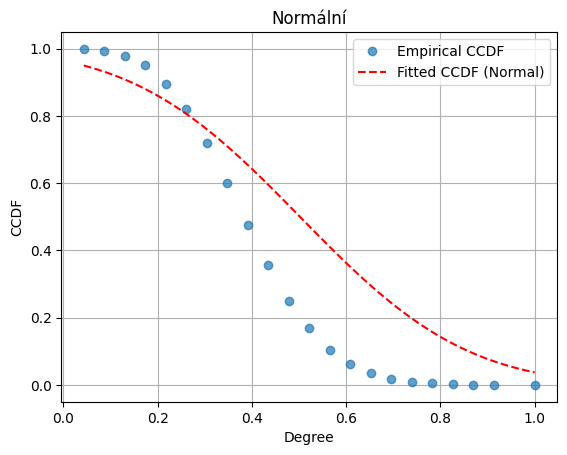

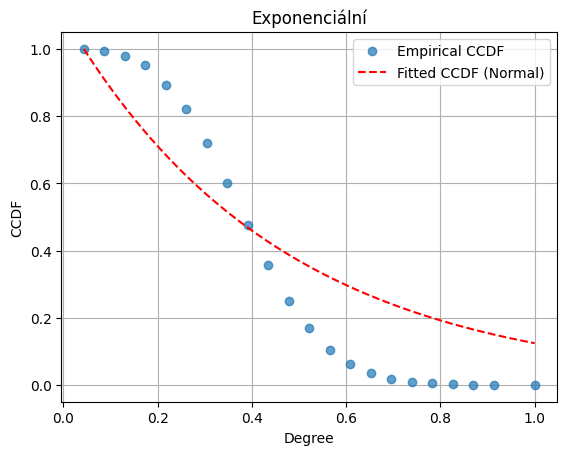

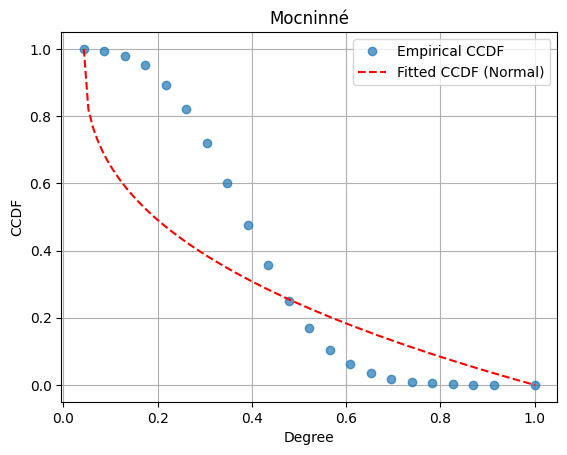

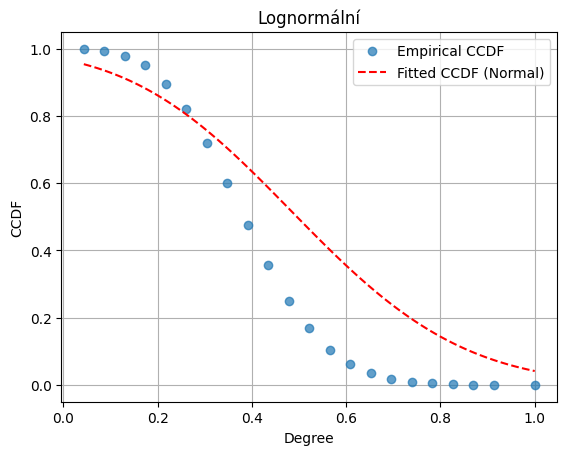

In [ ]:
random_df = df[df.Dataset == "Random"]
ba_df = df[df.Dataset == "BA"]

def plt_cddf(dataset, dist, label):
    dataset = dataset[dataset.X > 0]
    X = dataset.X.values
    ccdf = dataset.ccdf.values

    xmin, xmax = min(X), max(X)
    x = np.linspace(xmin, xmax, 100)
    fit_data = dist.fit(X)
    ccdf_fitted = 1 - dist.cdf(x, *fit_data)

    plt.plot(X, ccdf, 'o', label="Empirical CCDF", alpha=0.7)
    plt.plot(x, ccdf_fitted, '--', label="Fitted CCDF (Normal)", color="red")
    plt.xlabel("Degree")
    plt.ylabel("CCDF")
    plt.title(label)
    plt.legend()
    plt.grid(True)
    plt.show()
    
plt_cddf(random_df, stats.norm, "Normální")
plt_cddf(random_df, stats.expon, "Exponenciální")
plt_cddf(random_df, stats.powerlaw, "Mocninné")
plt_cddf(random_df, stats.lognorm, "Lognormální")

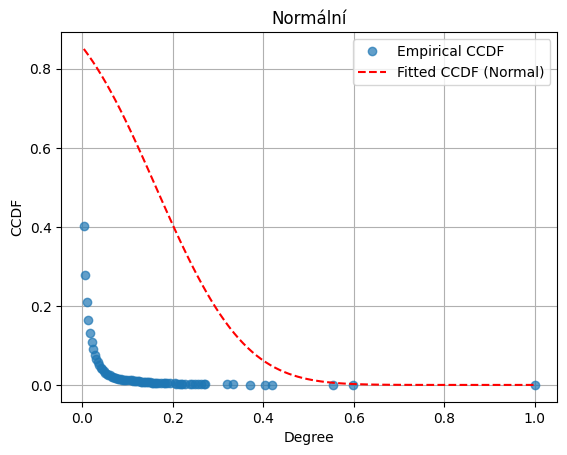

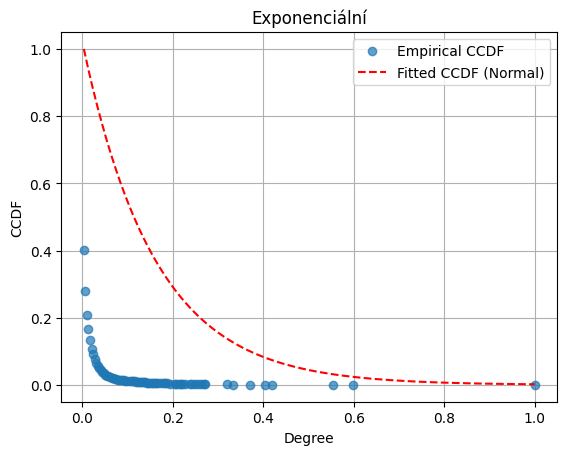

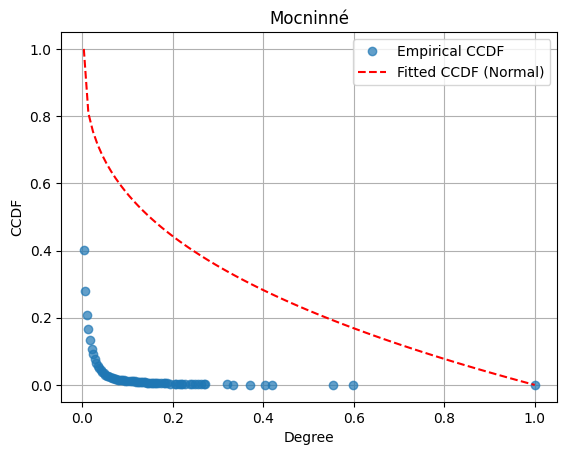

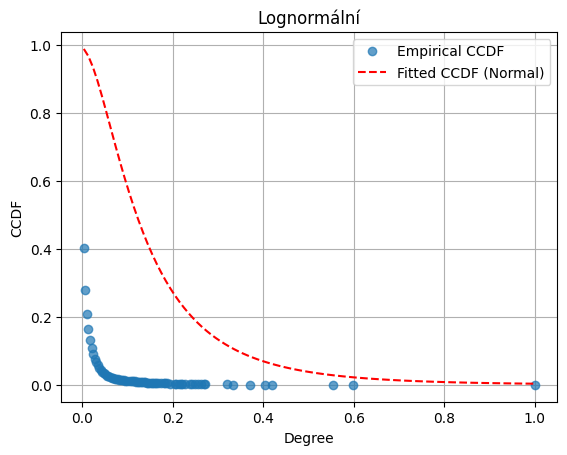

In [44]:
plt_cddf(ba_df, stats.norm, "Normální")
plt_cddf(ba_df, stats.expon, "Exponenciální")
plt_cddf(ba_df, stats.powerlaw, "Mocninné")
plt_cddf(ba_df, stats.lognorm, "Lognormální")